In [1]:
import pandas as pd
import numpy as np
import cmdstanpy as stan
import matplotlib.pyplot as plt

from modelling.util.data_loader import load_data

/Users/leevi/.pyenv/versions/3.10.0/envs/bda-venv/lib/python3.10/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
df = load_data()

In [40]:
df.iloc[:, :12].head()

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
0,40,1,ATA,140,289,0,Normal,172,0,0.0,Up,0
1,49,0,NAP,160,180,0,Normal,156,0,1.0,Flat,1
2,37,1,ATA,130,283,0,ST,98,0,0.0,Up,0
3,48,0,ASY,138,214,0,Normal,108,1,1.5,Flat,1
4,54,1,NAP,150,195,0,Normal,122,0,0.0,Up,0


In [30]:
df.columns

Index(['age', 'sex', 'chest_pain_type', 'resting_bp', 'cholesterol',
       'fasting_bs', 'resting_ecg', 'max_hr', 'exercise_angina', 'oldpeak',
       'st_slope', 'heart_disease', 'resting_ecg_st', 'resting_ecg_lvh',
       'chest_pain_ata', 'chest_pain_nap', 'chest_pain_asy', 'chest_pain_ta',
       'st_up', 'st_flat', 'st_down'],
      dtype='object')

In [ ]:
df.groupby('sex').heart_disease.agg(['count', 'mean'])

,count,mean
sex,,
0,193,0.259067
1,725,0.631724


In [28]:
df.groupby('chest_pain_type').heart_disease.agg(['count', 'mean'])

,count,mean
chest_pain_type,,
ASY,496,0.790323
ATA,173,0.138728
NAP,203,0.354680
TA,46,0.434783


In [ ]:
df.groupby('fasting_bs').heart_disease.agg(['count', 'mean'])

,count,mean
fasting_bs,,
0,704,0.480114
1,214,0.794393


In [31]:
df.groupby('resting_ecg').heart_disease.agg(['count', 'mean'])

,count,mean
resting_ecg,,
LVH,188,0.563830
Normal,552,0.516304
ST,178,0.657303


In [32]:
df.groupby('exercise_angina').heart_disease.agg(['count', 'mean'])

,count,mean
exercise_angina,,
0,547,0.351005
1,371,0.851752


In [33]:
df.groupby('st_slope').heart_disease.agg(['count', 'mean'])

,count,mean
st_slope,,
Down,63,0.777778
Flat,460,0.828261
Up,395,0.197468


In [41]:
from modelling.util.data_formatters import format_logreg_data
simple_model = stan.CmdStanModel(stan_file='modelling/stan_models/simple_regression.stan')
data = format_logreg_data(df)

fit = simple_model.sample(data)
summary = fit.summary()

summary.filter(regex=r'(alpha|beta)', axis=0)

INFO:cmdstanpy:compiling stan program, exe file: /Users/leevi/repos/bda-project/modelling/stan_models/simple_regression
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}
INFO:cmdstanpy:compiled model file: /Users/leevi/repos/bda-project/modelling/stan_models/simple_regression
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
ERROR:cmdstanpy:Chain 2 terminated by signal -2
ERROR:cmdstanpy:Chain 1 terminated by signal -2
ERROR:cmdstanpy:Chain 4 terminated by signal -2
ERROR:cmdstanpy:Chain 3 terminated by signal -2


KeyboardInterrupt: 

In [49]:
hier_model = stan.CmdStanModel(stan_file='modelling/stan_models/hierarchical_logistic_regression.stan')

INFO:cmdstanpy:compiling stan program, exe file: /Users/leevi/repos/bda-project/modelling/stan_models/hierarchical_logistic_regression
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}
INFO:cmdstanpy:compiled model file: /Users/leevi/repos/bda-project/modelling/stan_models/hierarchical_logistic_regression


In [10]:
data['X']

,age,sex,resting_bp,cholesterol,fasting_bs,max_hr,exercise_angina,oldpeak,resting_ecg_st,resting_ecg_lvh,chest_pain_ata,chest_pain_nap,chest_pain_asy,chest_pain_ta,st_up,st_flat,st_down
0,40,1,140,289,0,172,0,0.0,0,0,1,0,0,0,1,0,0
1,49,0,160,180,0,156,0,1.0,0,0,0,1,0,0,0,1,0
2,37,1,130,283,0,98,0,0.0,1,0,1,0,0,0,1,0,0
3,48,0,138,214,0,108,1,1.5,0,0,0,0,1,0,0,1,0
4,54,1,150,195,0,122,0,0.0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,110,264,0,132,0,1.2,0,0,0,0,0,1,0,1,0
914,68,1,144,193,1,141,0,3.4,0,0,0,0,1,0,0,1,0
915,57,1,130,131,0,115,1,1.2,0,0,0,0,1,0,0,1,0
916,57,0,130,236,0,174,0,0.0,0,1,1,0,0,0,0,1,0


In [17]:
df_shuffle = df.sample(frac=1, replace=False)
df_train = df_shuffle.iloc[:-200]
df_test = df_shuffle.iloc[-200:]

In [19]:
from modelling.util.data_formatters import format_logreg_data

In [22]:
train_fit = simple_model.sample(format_logreg_data(df_train))

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1


In [26]:
vars = train_fit.stan_variables()

In [27]:
test_data = format_logreg_data(df_test)

In [42]:
thetas = (test_data['X'].values @ vars['beta'].T) + vars['alpha']

In [59]:
y_preds = (1 / (1 + np.exp(-thetas)))  # logit transform

In [61]:
(y_preds.mean(axis=1).round() == test_data['y']).mean()

0.805

In [80]:
vars = fit.stan_variables()

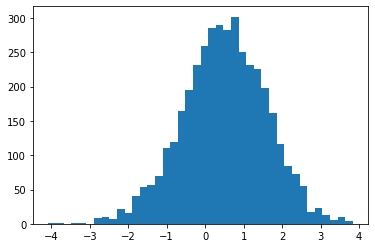

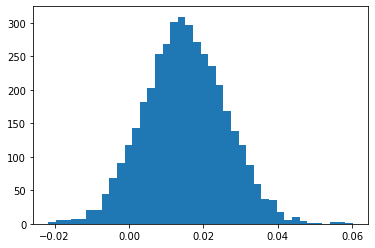

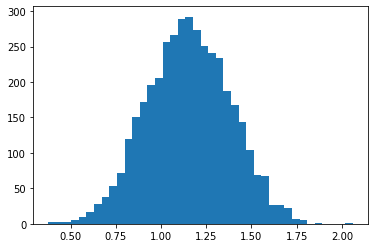

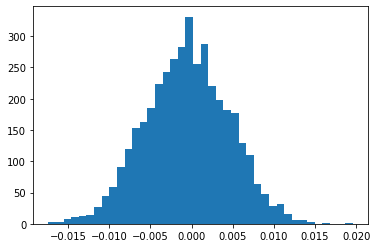

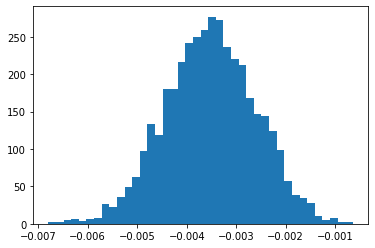

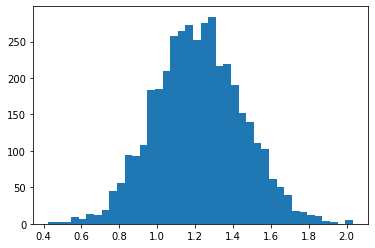

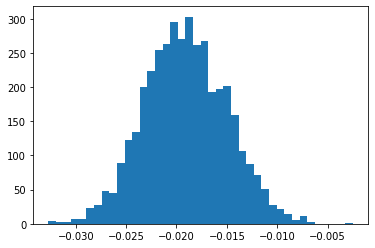

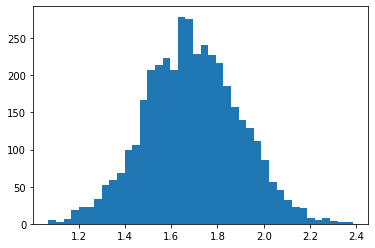

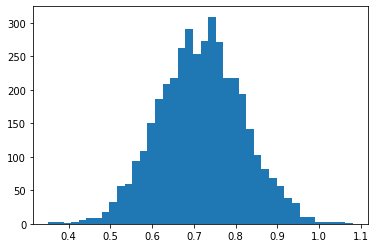

In [81]:
plt.hist(vars['alpha'], bins=40);
plt.show()
for i in range(vars['beta'].shape[1]):
    plt.hist(vars['beta'][:, i], bins=40);
    plt.show()

In [83]:
vars.keys()

dict_keys(['beta', 'alpha', 'theta'])

In [84]:
vars['theta']

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

/Users/leevi/.pyenv/versions/3.10.0/envs/bda-venv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6731: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/leevi/.pyenv/versions/3.10.0/envs/bda-venv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6732: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

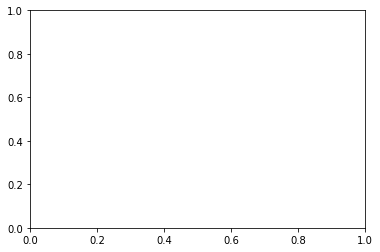

In [82]:
plt.hist(vars['theta'][:, 1], bins=40);